In [7]:
%load_ext autoreload
%autoreload 2
import pickle
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

from copy import deepcopy
from typing import Dict

import numpy as onp

import jax
from jax.random import split, PRNGKey, uniform
from jax import numpy as jnp

import optax

import brax
from brax.io.image import _scene
from brax.math import relative_quat

from pytinyrenderer import TinyRenderCamera as Camera
from pytinyrenderer import TinyRenderLight as Light
from google.protobuf import text_format

from istar_map_tqdm_patch import array_apply

from flax_transformer_v2 import (
    IndependentGaussianMixtures,
    IndependentGaussianMixtureConfig,
    GaussianMixturePosteriorConfig,
    TransformerConfig,
    gaussian_mixture_logpdf,
    gaussian_mixture_sample,
)

from learn_brax import(
    generate_single_example,
    sample_diffs_from_posterior,
    add_diffs_to_qp,
    build_render_args,
    render_depth_array,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def initialize_model_and_state(key:PRNGKey, obs_length, num_input_vars, num_output_grouped_vars, num_mixtures_per_output_group, lr, deterministic, load_idx=None):
    key, *sks = split(key, 10)
    
    m = IndependentGaussianMixtures(
        IndependentGaussianMixtureConfig(
            group_variables=num_output_grouped_vars, num_mixtures_per_group=num_mixtures_per_output_group
        ),
        GaussianMixturePosteriorConfig(),
        TransformerConfig(
            deterministic=deterministic
        ),
    )

    variables = m.init(
        {"params": sks[0], "dropout": sks[1]}, jnp.ones((2, obs_length, num_input_vars))
    )
    state, params = variables.pop('params')
    del variables

    tx = optax.adam(learning_rate=lr)
    opt_state = tx.init(params)
    if load_idx is not None:
        with open(f'params_{load_idx}', 'rb') as f:
            params = pickle.load(f)
        with open(f'opt_state_{load_idx}', 'rb') as f:
            opt_state = pickle.load(f)    
    return m, tx, opt_state, params, state

In [4]:
num_mixtures_per_output_group = (2, 8)
num_output_grouped_vars = (3,4)
m, tx, opt_state, params, _ = initialize_model_and_state(PRNGKey(85858), 
                                                         obs_length=999, 
                                                         num_input_vars=6, 
                                                         num_output_grouped_vars=(3,4), 
                                                         num_mixtures_per_output_group=(2,8), 
                                                         lr=0.0001, 
                                                         deterministic=True,
                                                         load_idx=18)

In [5]:
batch_qp, diffs, depths, point_clouds = generate_single_example(PRNGKey(3))
# d_params_list = jax.tree_map(lambda x: x[0], jax.jit(m.apply)({'params':params}, point_clouds))
d_params_list = jax.jit(m.apply)({'params':params}, point_clouds)
print(f"logpdf of ground truth under the predicted dist is {gaussian_mixture_logpdf(diffs['pos_diff'], d_params_list[0]) + gaussian_mixture_logpdf(diffs['rot_diff'],d_params_list[1])}")


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 112.05it/s]


logpdf of ground truth under the predicted dist is [7.6567383]


In [8]:
diffs = sample_diffs_from_posterior(PRNGKey(1345), d_params_list, 16)
qp_samples = add_diffs_to_qp(jax.tree_map(lambda x: x[0], batch_qp), diffs)
args = build_render_args(qp_samples, height=320, width=320, num_points=999)
depth_samples = depths = array_apply(render_depth_array, args, False)

100%|███████████████████████████████████████████| 16/16 [00:01<00:00, 12.18it/s]


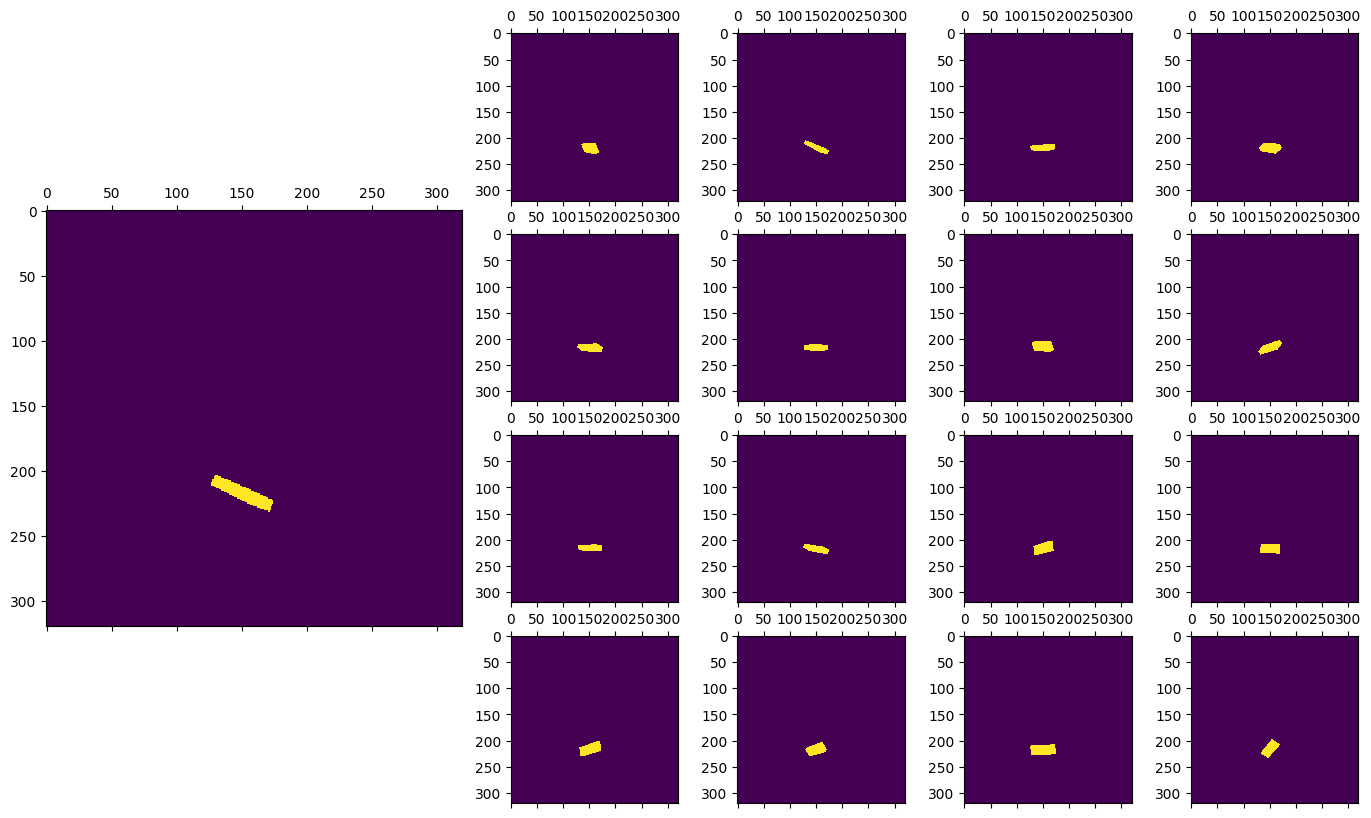

In [9]:
import math
fig = plt.figure(figsize=(20,10))
num_cols = 4
big_size = 3
gs = GridSpec(nrows=max(big_size,num_cols), ncols=big_size + num_cols)
ax0 = fig.add_subplot(gs[:,:big_size-1])
ax0.matshow(depths[1])
for i in range(len(depth_samples)):
    c = i % num_cols
    r = math.floor(i/num_cols)
    ax = fig.add_subplot(gs[r, big_size + c-1])
    ax.matshow(depth_samples[i])
# ax1 = fig.add_subplot(gs[0,2])
# ax1.matshow(depth_samples[0])

# ax1 = fig.add_subplot(gs[0,3])
# ax1.matshow(depth_samples[1])

In [10]:
%%time
def procedure(load_save):
    key, *sks = split(PRNGKey(12345), 10)
    generation_size = 200000
    batch_size = 300
    obs_length = 999
    num_epochs = 999999
    load_idx = load_save
    save_idx = load_save+1

    m = IndependentGaussianMixtures(
        IndependentGaussianMixtureConfig(
            group_variables=(3, 4), num_mixtures_per_group=(2, 8)
        ),
        GaussianMixturePosteriorConfig(),
        TransformerConfig(),
    )

    variables = m.init(
        {"params": sks[0], "dropout": sks[1]}, jnp.ones((batch_size, obs_length, 6))
    )
    state, params = variables.pop('params')
    del variables
    
    params_checkpoints = {}
    save_params = 10

    tx = optax.adam(learning_rate=0.0001)
    opt_state = tx.init(params)

    with open(f'params_{load_idx}', 'rb') as f:
        params = pickle.load(f)
    with open(f'opt_state_{load_idx}', 'rb') as f:
        opt_state = pickle.load(f)    
    with open(f'key_{load_idx}', 'rb') as f:
        loaded_key = pickle.load(f)    
    

    finished = False
    print_every = 20
    for e in range(num_epochs):
        old_key = key
        key = loaded_key if e == 0 else key
        key, subkey = split(key)
        diffs, p_clouds = generate_data_batch(subkey, generation_size, num_points=obs_length)
        for i in range(generation_size//batch_size - 1):
            if (i+1) % save_params == 0:
                params_checkpoints[f'opt_state_{e}_{i}'] = jax.tree_map(onp.array,opt_state)
                params_checkpoints[f'params_{e}_{i}'] = jax.tree_map(onp.array,params)
                params_checkpoints[f'key_{e}_{i}'] = jax.tree_map(onp.array,key)
            key, subkey = split(key)
            # opt_state, params, l = update_step(
            opt_state, params, l = jax.jit(update_step, static_argnums=(0,7))(
                m.apply,
                p_clouds = jnp.array(p_clouds[i*batch_size: (i+1)*batch_size]),
                latents_list = [jnp.array(diffs['pos_diff'][i*batch_size: (i+1)*batch_size]), 
                                jnp.array(diffs['rot_diff'][i*batch_size: (i+1)*batch_size])],
                opt_state=opt_state,
                params = params,
                state = state,
                dropout_key=subkey,
                tx=tx,
            )
            if i%print_every == 0:
                print(e,i,l)
                # print(e,i,0)
            if jnp.isnan(l) or l == 0:
            # if  (e==89 and i == 499):
                print('failed',e,i,l)
                finished = True
                break
            with open(f'params_{save_idx}','wb') as f:
                    pickle.dump(params, f)
            with open(f'opt_state_{save_idx}','wb') as f:
                    pickle.dump(opt_state, f)
            with open(f'key_{save_idx}','wb') as f:
                    pickle.dump(old_key, f)

        if finished:
            break

CPU times: user 2 µs, sys: 7 µs, total: 9 µs
Wall time: 16.9 µs


In [10]:
load_save=22

{'pos_diff': array([[1.6287904, 1.6328505, 1.6305003]], dtype=float32),
 'rot_diff': array([[0.5777364 , 0.47153807, 0.4710247 , 0.47113076]], dtype=float32)}

In [13]:
params = params_checkpoints['params_89_499']
# params_checkpoints['params_89_499']

In [20]:
m2 = IndependentGaussianMixtures(
    IndependentGaussianMixtureConfig(
        group_variables=(3, 4), num_mixtures_per_group=(2, 8)
    ),
    GaussianMixturePosteriorConfig(),
    TransformerConfig(deterministic=True),
)
variables = m2.init({"params": sks[0]}, jnp.ones((batch_size, obs_length, 6)))
state, _ = variables.pop('params')
del variables


In [162]:
from flax_transformer_v2 import gaussian_mixture_sample
gaussian_mixture_sample(PRNGKey(9999), d_params_list[0])
# jax.nn.softmax(gaussian_mixture_sample(PRNGKey(12), d_params_list[1]))
# jax.nn.softmax(d_params_list[1]['mix_p']), d_params_list[1]['mix_p']
jax.tree_map(lambda x: x.shape, params['TransformerStack_0'])

FrozenDict({
    DecoderLayer_0: {
        LayerNorm_0: {
            bias: (100,),
            scale: (100,),
        },
        LayerNorm_1: {
            bias: (100,),
            scale: (100,),
        },
        LayerNorm_2: {
            bias: (100,),
            scale: (100,),
        },
        MlpBlock_0: {
            Dense_0: {
                bias: (200,),
                kernel: (100, 200),
            },
            Dense_1: {
                bias: (100,),
                kernel: (200, 100),
            },
        },
        MultiHeadDotProductAttention_0: {
            key: {
                kernel: (100, 4, 25),
            },
            out: {
                kernel: (4, 25, 100),
            },
            query: {
                kernel: (100, 4, 25),
            },
            value: {
                kernel: (100, 4, 25),
            },
        },
        SelfAttention_0: {
            key: {
                kernel: (100, 4, 25),
            },
            out: {


In [150]:
batch_qp, diffs, depths, point_clouds = generate_single_example(PRNGKey(788575))
d_params_list = jax.jit(m2.apply)({'params':params}, point_clouds)

# print(jnp.concatenate([mix_p,mix_p], axis=0))
# cat_sample = jax.random.categorical(PRNGKey(0), jax.lax.log(jnp.concatenate([mix_p,mix_p], axis=0)), axis=-1)
# cat_sample, n_sample,v_select_mixture_sample(n_sample, cat_sample)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 112.68it/s]


({'pos_diff': array([[[-2.0783248,  2.006081 ,  3.2510986]]], dtype=float32),
  'rot_diff': array([[[-0.14963257, -0.6045985 , -0.37429586,  0.68700314]]],
        dtype=float32)},
 DeviceArray([[-3.6311328,  3.1834471,  5.4816566]], dtype=float32),
 DeviceArray([[-3.0552585 , -0.40731323,  0.01829538, -0.16090162]], dtype=float32))

In [173]:
pos_dif = gaussian_mixture_sample(PRNGKey(9999), d_params_list[0])
rot_dif = gaussian_mixture_sample(PRNGKey(8888), d_params_list[1])
new_pos = batch_qp['pos']+pos_dif
batch_qp['pos'], new_pos
# brax.math.quat_mul(diffs['rot_diff'][0][0], batch_qp['rot'][0][0]), brax.math.quat_mul(rot_dif[0], batch_qp['rot'][0][0])


(array([[[ 1.9589419 , -1.2487664 , -1.3561602 ]],
 
        [[-0.11938286,  0.7573147 ,  1.8949385 ]]], dtype=float32),
 DeviceArray([[[-1.6721909,  1.9346807,  4.1254964]],
 
              [[-3.7505157,  3.9407618,  7.376595 ]]], dtype=float32))

In [340]:
sys = brax.System(my_env)
# PIL.Image.fromarray(image.render_array(sys, sys.default_qp(), camera = get_default_camera(width=640, height=640),width=640, height=640))
rot = sample_box_rotation(jax.random.PRNGKey(1234), angle=-jnp.pi/2, img=jnp.array([0.0,1.0,0.0]))
my_qp = sys.default_qp() + brax.physics.base.Q(pos=jp.array([[-2.0,-2.0,-2.0]]),rot=jp.array(rot))
rot, my_qp, jnp.linalg.norm(my_qp.rot), sys.default_qp()

[0.70710677] [-0.        -0.7071068 -0.       ] -1.5707963267948966


(DeviceArray([-0.29289323,  0.        , -0.7071068 ,  0.        ], dtype=float32),
 QP(pos=array([[-2.   , -2.   , -1.875]]), rot=DeviceArray([[ 0.70710677,  0.        , -0.7071068 ,  0.        ]], dtype=float32), vel=array([[0., 0., 0.]]), ang=array([[0., 0., 0.]])),
 DeviceArray(1., dtype=float32),
 QP(pos=array([[0.   , 0.   , 0.125]]), rot=array([[1., 0., 0., 0.]]), vel=array([[0., 0., 0.]]), ang=array([[0., 0., 0.]])))

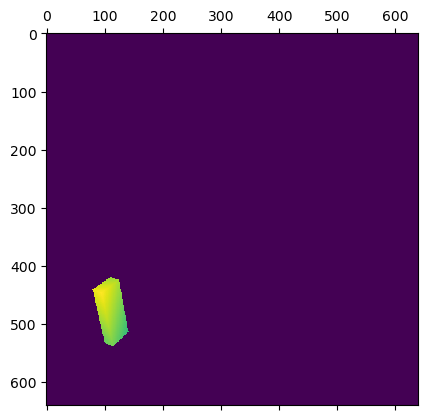

In [341]:
scene, instances = _scene(sys, my_qp)
camera = get_default_camera(width=640, height=640)
x = scene.get_camera_image(instances, get_default_light(), camera)
x = onp.array(x.depthbuffer)
x[x<=4.0e+04] = -10
# x.max()
# sns.displot(x = x[x>-8], kind="kde")
plt.matshow(onp.reshape(x, (camera.view_height, camera.view_width)))
# PIL.Image.fromarray(x.reshape(camera.view_height, camera.view_width, -1).repeat(3,axis=2))

In [117]:
from dataclasses import field

@struct.dataclass
class IndependentGaussianMixtureConfig:
  #sequence with the number of variables on each group (each group modeled with a gaussian mixture)
  group_variables: Sequence[int] = field(default=(3, 4), init=False)
  #number of mixtures used on each group
  num_mixtures_per_group: Sequence[int] = (2,8)



FrozenInstanceError: cannot assign to field 'group_variables'